# 13 - QAOA parameters optimization with different optimization algorithms

This notebook will provide a brief overview of all the optimizers available in OpenQAOA for optimizing the QAOA parameters. If you would like to learn more about what an optimizer is and obtain a more comprehensive explanation of all the methods implemented in the library, please refer to our documentation on this topic at https://openqaoa.entropicalabs.com/optimizers/shot-adaptive-optimizers/.

## Create a problem instance
We begin by creating a problem instance for a simple MinimumVertexCover problem for a random graph created using the `random_instance` method of the class.

In [1]:
from openqaoa.problems import MinimumVertexCover

# Use the MinimumVertexCover class to instantiate the problem, and get the QUBO representation of the problem
prob = MinimumVertexCover.random_instance(n_nodes=10, edge_probability=0.9, seed=10)
qubo = prob.qubo

### Extract the exact solution for a small enough problem



In [2]:
from openqaoa.utilities import ground_state_hamiltonian # import the brute-force solver to obtain exact solution

energy, configuration = ground_state_hamiltonian(qubo.hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: 8.0, Solution: ['1111111001', '1011111101', '1111110011', '1111001111', '1110101111', '1011101111']


## Running QAOA with gradient-based optimizers

The simplest optimizer is Gradient descent. It works by repeatedly adjusting the parameters of the function in the direction of the negative gradient of the function. The size of the adjustment is controlled by a hyperparameter called the step size, which determines how far to step in the direction of the negative gradient. By repeating this process over many iterations, gradient descent can converge to a local minimum of the function, which may or may not be the global minimum.

The gradient descent optimizer updates the values in each iteration by applying the following rule:

$$ \vec\gamma^{(k+1)} = \vec\gamma^{(k)} - \alpha \vec\nabla f(\vec\gamma^{(k)}), $$

where $\vec\gamma^{(k)}$ is the set of parameters at the $k\text{-th}$ iteration, $f$ the cost function and $\alpha$ is the step size.

In the code below it is shown how to run QAOA with the gradient decent optimizer, using a step size $\alpha=0.001$ and approximating the Jacobian $\vec\nabla f$ with finite difference method.

In [3]:
from openqaoa import QAOA 

# create the QAOA object
q_vgb = QAOA()

# set optimizer and properties
q_vgb.set_classical_optimizer(
    maxiter=100,
    method='vgd', 
    jac="finite_difference", 
    optimizer_options=dict(stepsize=0.001)
)

# compile and optimize using the chosen optimizer
q_vgb.compile(qubo)

As you can see, the argument `optimizer_options` expects a dictionary with the hyperparameters of the choosen optimizer. If left in blank, the default values will be used.

In [4]:
# optimize qaoa parameters and print the optimized cost
q_vgb.optimize()
print("Optimized cost with VGD:", q_vgb.result.optimized['cost'])

Optimized cost with VGD: 102.503223711639


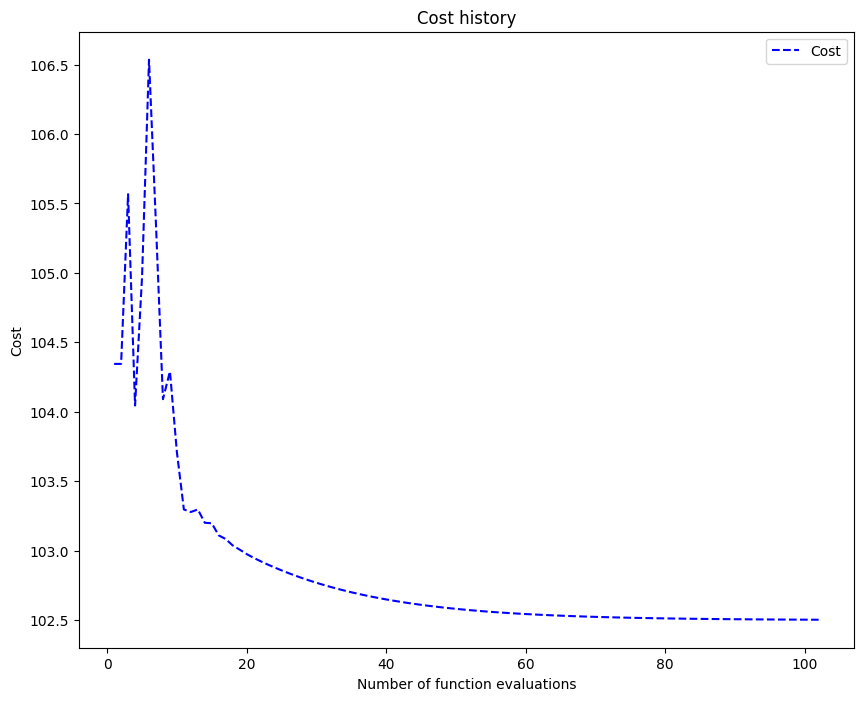

In [5]:
# plot the optimization history
fig, ax = q_vgb.result.plot_cost()

### The effect of the step size value

The choice of step size in gradient descent impacts how quickly the algorithm converges to the minimum of the function. A larger step size leads to faster convergence, while a smaller step size leads to slower convergence. However, if the step size is too large, the algorithm may overshoot the minimum or even fail to converge at all.

Let us see a comparison:

In [6]:
list_qaoa=[]

#let us run it with different step sizes
for stepsize in [0.01, 0.005, 0.001, 0.0001]:
    q = QAOA()
    q.set_classical_optimizer(
        maxiter=100,
        method='vgd', 
        jac="finite_difference", 
        optimizer_options={'stepsize':stepsize}
    )
    q.compile(qubo)
    q.optimize()

    list_qaoa.append(q)

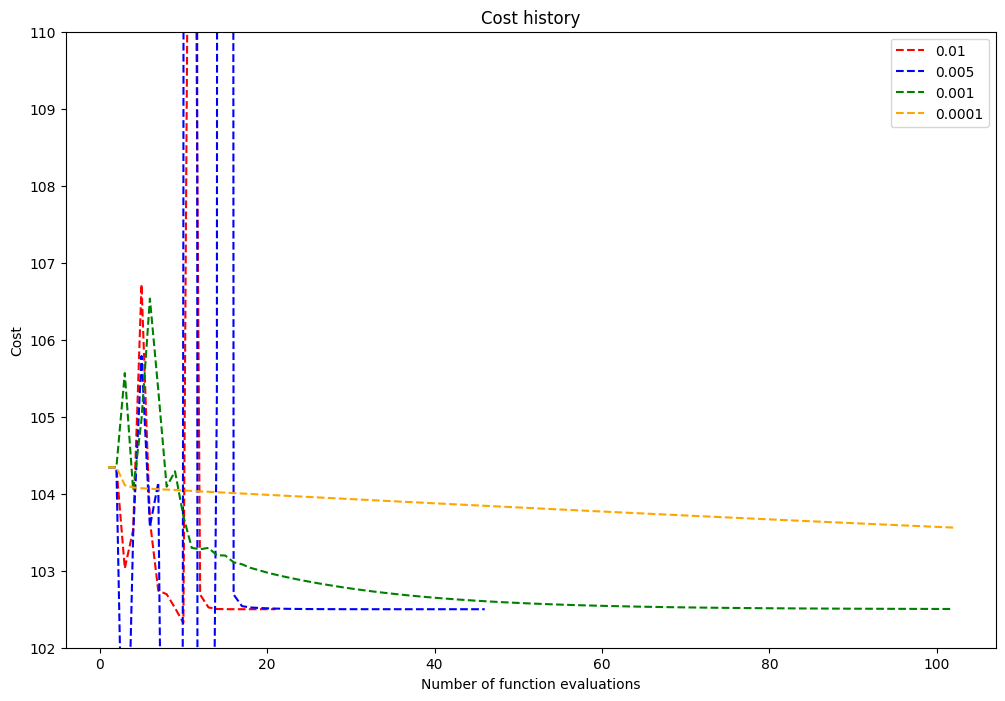

In [7]:
import matplotlib.pyplot as plt

# plot all the cost histories together
fig, ax = plt.subplots(1,1,figsize=(12,8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, q in enumerate(list_qaoa):
    stepsize=q.optimizer.options['stepsize']
    fig, ax = q.result.plot_cost(label=stepsize, ax=ax, color=colors[i])

ax.set_ylim([102, 110])

fig.show()

We can see how with the step sizes $\alpha = 0.01, 0.005$ the cost varies very fast, and it is difficult to see a clear convergence. 

### Other gradient-based optimizers

In OpenQAOA, apart from the gradient descent optimizers, there are other gradient-based optimizers implemented. Here there is a list of those:

| Name | Method      | Description  | Hyperparameters |
| :-------------- | :--------- | :-------------------- | :--- |
|`vgd`            | Gradient Descent  | Vanilla gradient-descent optimizer. | `stepsize` |
| `rmsprop`        | Root Mean Squared Propagation | Adaptive learning rate optimization method that uses a moving average of squared gradients to normalize the gradient. | `stepsize`, `decay`, `eps` |
| `newton`         | Newton's method | Second-order optimization method that uses the Hessian matrix. | `stepsize`|
| `natural_grad_descent` | Quantum Natural Gradient Descent | A quantum optimization method that leverages the geometry of the parameter space and the quantum Fisher information matrix to improve convergence speed. | `stepsize`|
| `spsa`           | Simultaneous Perturbation Stochastic Approximation | A gradient-free optimization method that uses stochastic approximations of the gradient. | `stepsize` |

Also, there are two more gradient-based optimizers available: `newton-cg`, `l-bfgs-b`.
These are included in the library `scipy.optimize.minimize`, please refer to [their documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to learn more about them. 

For further information regarding the construction of these optimization methods and what outcomes to anticipate from them, we invite you to explore our documentation at https://openqaoa.entropicalabs.com/optimizers/gradient-based-optimizers/.

### Other type of Jacobian computation

In the example above we are using the finite difference method to approximate the Jacobian. However, in OpenQAOA there are implemented other three methods that help us to compute it. Here is a list of those:

| Name | Method | Description | Hyperparameters |
| :--- | :----- | :---------- |:---------- |
| `finite_difference` | Finite Difference  | Approximates the gradient by evaluating the function at points that are slightly perturbed from the current point. | `stepsize`|
| `param_shift` | Parameter-shift | Compute exact derivative by evaluating the circuit at two points offset by $\pi/2$ from the parameter value using the parameter-shift rule.| |
| `stoch_param_shift` | Stochastic Parameter-shift | Approximates derivative by adding random components to the parameter-shift rule. |`n_beta_single`, `n_beta_pair`, `n_gamma_single`, `n_gamma_pair`|
| `grad_spsa` | Gradient Simultaneous Perturbation Stochastic Approximation | A method for stochastic gradient descent that estimates the gradient using a finite-difference approximation with random perturbations of the parameters. | `stepsize`|

Here you can see an example using `stoch_param_shift`:

In [8]:
# create the QAOA object
q = QAOA()

# set optimizer and properties
q.set_classical_optimizer(
    method='vgd', 
    jac="stoch_param_shift",
    optimizer_options=dict(
        stepsize=0.001
    ),
    jac_options=dict(
        n_beta_single=4,
        n_gamma_pair=6,
    ),
)

# compile
q.compile(qubo)

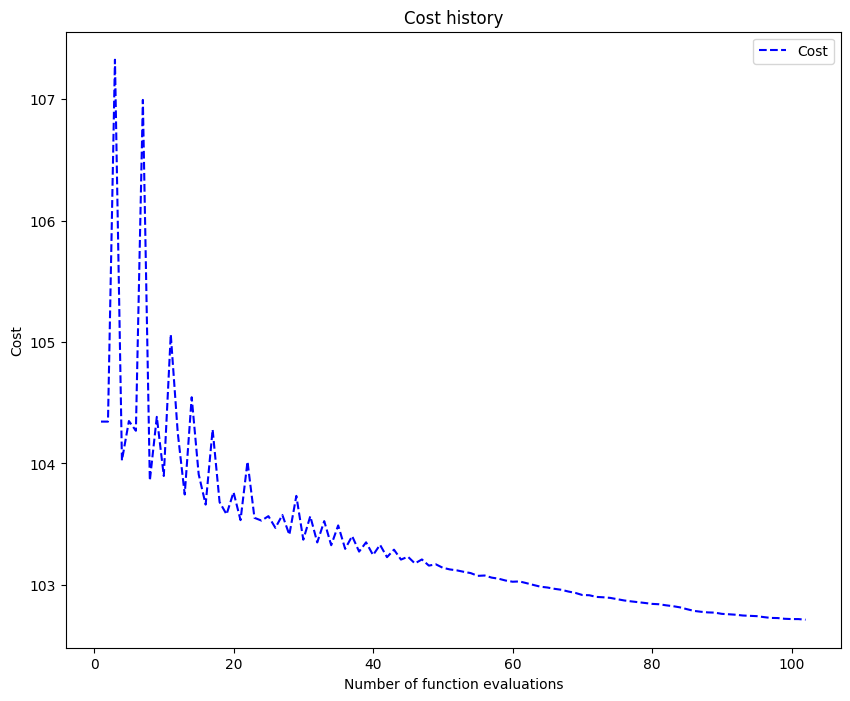

In [9]:
# optimize using the chosen optimizer and the chosen jacobian computation method
q.optimize()

# plot the optimization history
fig, ax = q.result.plot_cost()

For further information regarding these computations methods and what outcomes to anticipate from them, we invite you to explore our documentation at https://openqaoa.entropicalabs.com/optimizers/gradient-based-optimizers/.

## Running QAOA with gradient-free optimizers

Another type of optimization algorithms are those that don't require an approximation of the Jacobian, the so-called gradient-free optimizers. The optimizers available are those that are included in the library `scipy.optimize.minimize`, please refer to [their documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to learn more about them. 

Here you can find a list of the name of the current available optimizers: `nelder-mead`, `powell`, `cg`, `bfgs`,  `tnc`, `cobyla`, `slsqp`, `trust-constr`, `dogleg`, `trust-ncg`, `trust-exact`, `trust-krylov`.

_Note that this list is subject to changes, as new optimizers could be implemented in future versions of the library._


In the code below we display an example using `cobyla`:

In [10]:
# initialize the QAOA object
q_cobyla = QAOA()

# set the classical optimizer to COBYLA,
q_cobyla.set_classical_optimizer(maxiter=40, method='COBYLA')

# compile
q_cobyla.compile(qubo)

In [11]:
# optimize qaoa parameters
q_cobyla.optimize()
print("Optimized cost with COBYLA:", q_cobyla.result.optimized['cost'])

Optimized cost with COBYLA: 60.964879066548


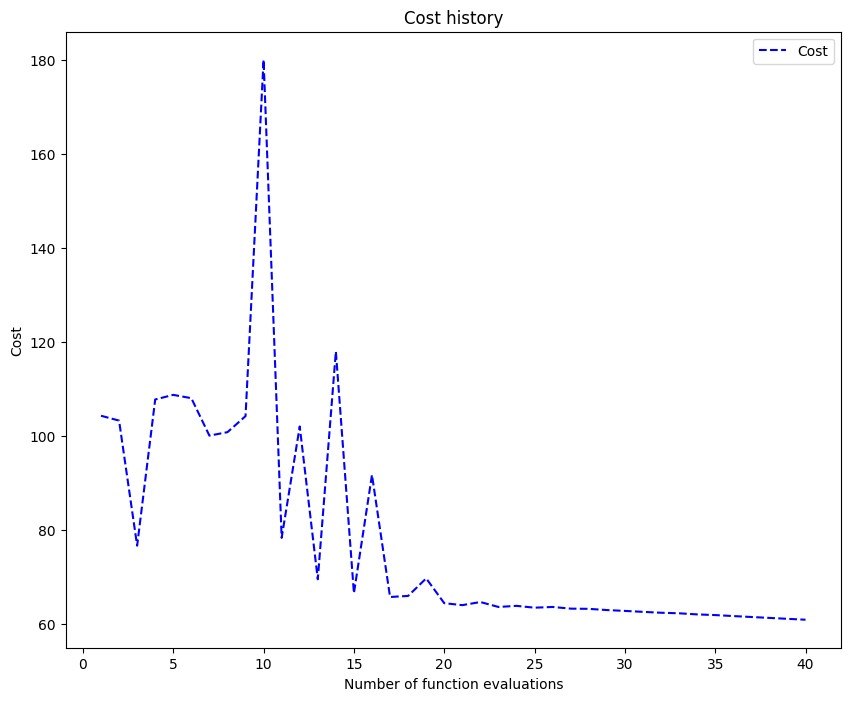

In [12]:
# plot the optimization history
fig, ax = q_cobyla.result.plot_cost()

## Optimizers adapted from PennyLane library

In addition to the gradient-based and gradient-free optimizers discussed above, some of the optimizers from the PennyLane library have been adapted for use with OpenQAOA. The following table shows this adapted optimizers:

| OpenQAOA name | PennyLane name | Method | Description |
| :------------ | :------------- | :----- | :---------- |
|`pennylane_adagrad` | `AdagradOptimizer` | Adagrad | Gradient-descent optimizer with past-gradient-dependent learning rate in each dimension. |
|`pennylane_adam` | `AdamOptimizer` | Adam | Optimizer for building fully trained quantum circuits by adding gates adaptively. |
|`pennylane_vgd` | `GradientDescentOptimizer` | Gradient Descent | Vanilla gradient-descent optimizer. |
|`pennylane_momentum` | `MomentumOptimizer` | Momentum Gradient Descent | Gradient descent optimizer with momentum. |
|`pennylane_nesterov_momentum` | `NesterovMomentumOptimizer` | Nesterov Momentum Gradient Descent | Gradient descent optimizer with Nesterov momentum. |
|`pennylane_rmsprop` | `RMSPropOptimizer` | Root Mean Squared Propagation | Adaptive learning rate optimization method that uses a moving average of squared gradients to normalize the gradient.|
|`pennylane_rotosolve` | `RotosolveOptimizer` | Rotosolve | Gradient-free optimizer that updates circuit parameters by separately reconstructing the cost function for each parameter while holding all other parameters constant. |
|`pennylane_spsa` | `SPSAOptimizer` | Rotosolve | A gradient-free optimizer that uses stochastic approximations of the gradient. |

For more information on these optimizers and their hyperparameters, we recommend referring to the [PennyLane optimizers documentation](https://docs.pennylane.ai/en/stable/introduction/interfaces.html#optimizers).


_It's worth noting that some of the optimizers from the PennyLane library, namely Gradient Descent, RMSProp, and SPSA, are already directly implemented in OpenQAOA. This means that using `pennylane_vgd` is equivalent to using `vgd`, `pennylane_rmsprop` is equivalent to `rmsprop`, and `pennylane_spsa` is equivalent to `spsa`._


**Example**

In this example, we demonstrate how to run a QAOA by using an optimizer adapted from the PennyLane library in OpenQAOA. Specifically, we use `pennylane_nesterov_momentum` optimizer, which updates the parameters according to the following formula:

$$ \vec\gamma^{(k+1)} = \vec\gamma^{(k)} - \vec a^{(t+1)}, $$

where

$$ \vec a^{(t+1)}=m \,\vec a^{(t)}+\alpha \vec \nabla f\left(\vec\gamma^{(k)}-m \,\vec a^{(t)}\right),$$

here, $\alpha$ denotes the step size, and $m$ denotes the momentum.

The following code shows how to use `pennylane_nesterov_momentum` in OpenQAOA. In this example, we approximate the Jacobian using `finite_difference`, and we then set the maximum number of iterations to 200 and customize the optimizer by setting the step size to 0.015 and the momentum to 0.5.

In [13]:
# create the QAOA object
q = QAOA()

# set optimizer and properties
q.set_classical_optimizer(
    method='pennylane_nesterov_momentum',     
    jac='finite_difference',
    maxiter=200,
    optimizer_options=dict(stepsize=0.0009,momentum=0.2)
)

# compile
q.compile(qubo)

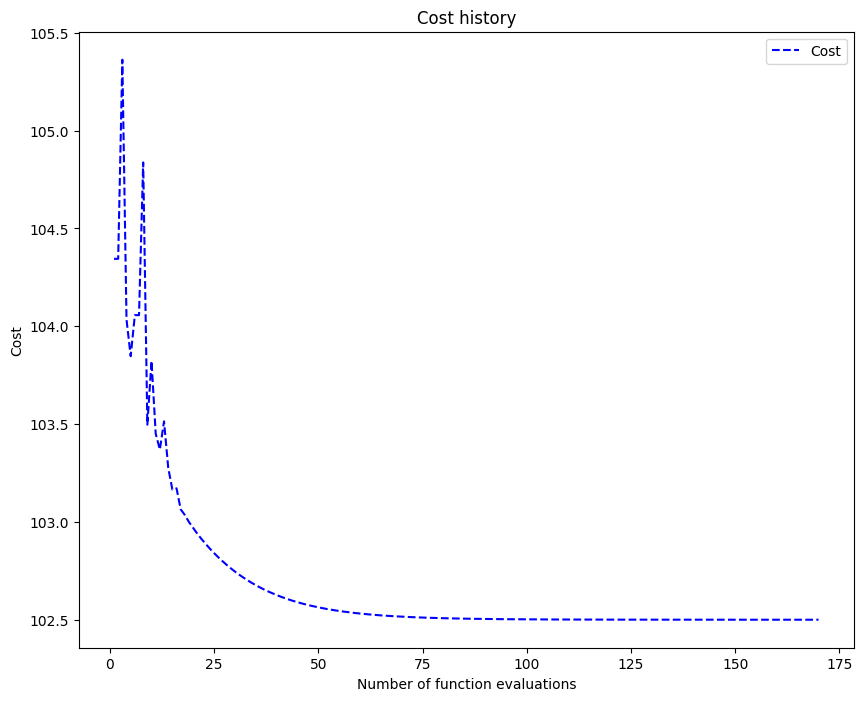

In [14]:
# optimize the qaoa parameters with the chosen optimizer
q.optimize()

# plot the optimization history
fig, ax = q.result.plot_cost()

## Running QAOA with shot-adaptive optimizers

There is a type of optimizers that we call Shot-adaptive optimizers. These are a variant of gradient-based optimizers that use properties of quantum computers to improve the optimization process. Specifically, they take advantage of the fact that to evaluate the cost function in a quantum computer, you need to repeat the evaluation of the circuit multiple times -what we call "number of shots"-. At each iteration, shot-adaptive optimizers update the parameters by computing the gradient approximation using a varying number of shots. To read more about them refer to our documentation https://openqaoa.entropicalabs.com/optimizers/shot-adaptive-optimizers/. 

In OpenQAOA there are two shot-adaptive optimizers implemented: `cans` and `icans`. Both of them are constructed to work efficiently using the parameter-shift rule for the Jacobian computation, and use very similar strategies to update the number of shots to be used in the next iteration. However, `cans` always uses the same number of shots for each partial gradient computation and `icans` will choose different number of shots for each partial computation.

Here is an example using `icans`:

In [15]:
from openqaoa.backends import create_device

# create the QAOA object
q = QAOA()

# we need to use a QPU or a shot-based simulator to use shot-adaptive optimizers
q.set_device(create_device('local', 'qiskit.shot_simulator'))
# we need to set the default number of shots
q.set_backend_properties(n_shots=500)

# set optimizer and properties
q.set_classical_optimizer(
    method='icans', 
    jac="param_shift", 
    maxiter=100,
    optimizer_options=dict( 
        stepsize=0.001,
        n_shots_min=10,
        n_shots_max=100,
        n_shots_budget=50000,
    )
)

# compile
q.compile(qubo)

You can see that the minimum number of shots for each gradient computation it has been set to 10 (`n_shots_min=10`) and the maximum to 100 (`n_shots_max=100`). Also, we have given a maximum number of circuit evaluation in total: `n_shots_budget=50000`, once this budget is reached the iteration will stop (this attribute can be left blank and there will be no budget).

In [16]:
# optimize qaoa parameters
q.optimize()

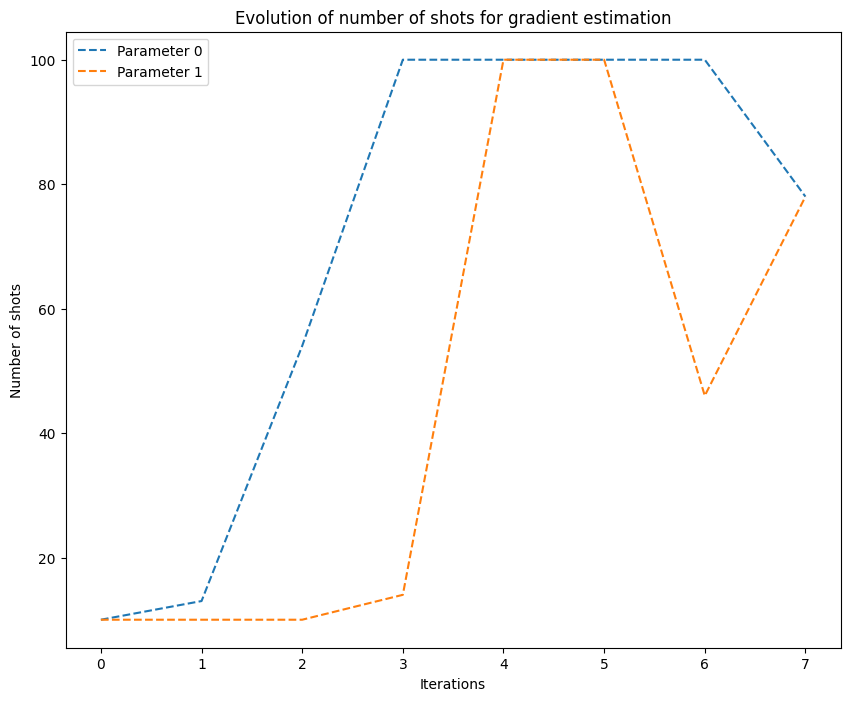

In [17]:
# plot the number of shots used for each partial gradient in each iteration
fig, ax = q.result.plot_n_shots()

## List of all optimizers available

The following is a comprehensive list of all optimization algorithms available in OpenQAOA:

- __*Gradient-free optimizers*__: `nelder-mead`, `powell`, `cg`, `bfgs`, `tnc`, `cobyla`, `slsqp`, `trust-constr`, `dogleg`, `trust-ncg`, `trust-exact`, and `trust-krylov`.
- __*Gradient-based optimizers*__: `vgd`, `newton`, `rmsprop`, `natural_grad_descent`, `spsa`, `l-bfgs-b`, and `newton-cg`.
- __*PennyLane optimizers*__: `pennylane_adagrad`, `pennylane_adam`, `pennylane_vgd`, `pennylane_momentum`, `pennylane_nesterov_momentum`, `pennylane_rmsprop`, `pennylane_rotosolve`, and `pennylane_spsa`.
- __*Shot adaptive optimizers*__: `cans`, and `icans`.